# Model to classify 20 tree species based on LeafSnap data subset

### Settings

In [12]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

### Load the data and split into train, test and validation

In [13]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-20subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (3283, 64, 64, 3)
Labels one hot size:  (3283, 20)
Number of images:  3283


,filename,label,source,label_numeric,path
3278,13002204347915.jpg,Salix nigra,field,14,dataset/images/field/salix_nigra/1300220434791...
3279,wb1193-06-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
3280,13002204347905.jpg,Salix nigra,field,14,dataset/images/field/salix_nigra/1300220434790...
3281,wb1220-03-2.jpg,Magnolia acuminata,lab,7,dataset/images/lab/Auto_cropped/magnolia_acumi...
3282,pi2201-01-1.jpg,Diospyros virginiana,lab,6,dataset/images/lab/Auto_cropped/diospyros_virg...


### Split the data into train, test and validation

In [14]:
[images_train, images_val, images_test, 
 labels_one_hot_train, labels_one_hot_val, labels_one_hot_test,
 end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - train set: ', np.shape(images_train))
print('Labels size - train set: ', np.shape(labels_one_hot_train)) 
print('Image size - valid. set: ', np.shape(images_val))
print('Labels size - valid. set: ', np.shape(labels_one_hot_val)) 
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)
    

Image size - train set:  (2626, 64, 64, 3)
Labels size - train set:  (2626, 20)
Image size - valid. set:  (328, 64, 64, 3)
Labels size - valid. set:  (328, 20)
Image size - test set:  (329, 64, 64, 3)
Labels size - test set:  (329, 20)
Indicies:  2626 ,  2954


In [15]:
# splitting some of of the info data

labels_train = info_data.loc[:end_train_ind, "label"]
sources_train = info_data.loc[:end_train_ind, "source"]

labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

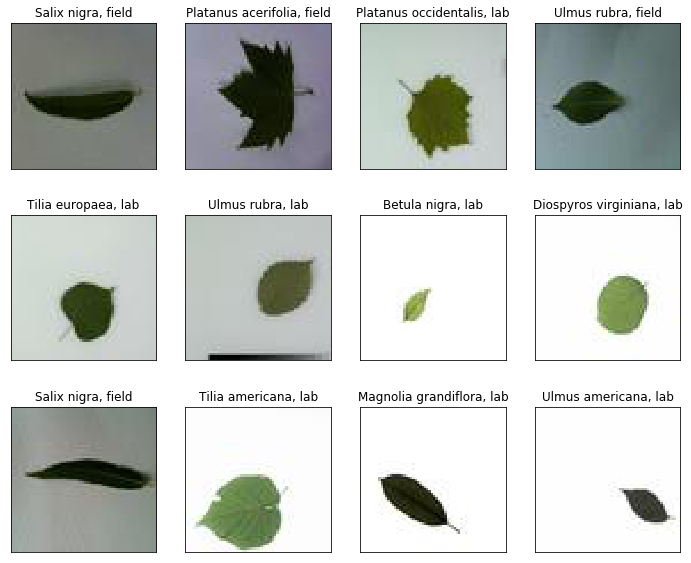

In [16]:
# plot random train images
d.plot_12images(images_train, labels_train, sources_train, figsize=(12,10))

### Data formatting

In [17]:
img_rows = 64
img_cols = 64
img_channels = 3
#print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], img_channels, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], img_channels, img_rows, img_cols)
    images_val = images_val.reshape(images_val.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, img_channels)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, img_channels)
    images_val = images_val.reshape(images_val.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print("Size of training data: ", np.shape(images_train))
print("Size of validation data: ", np.shape(images_val))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (2626, 64, 64, 3)
Size of validation data:  (328, 64, 64, 3)
Size of testing data:  (329, 64, 64, 3)


## Construct the model

In [18]:
model = m.generate_model(input_shape, 20)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 60, 60, 16)        1216      
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 26, 26, 32)        12832     
_________________________________________________________________
maxpooling2d_layer2 (MaxPool (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 5408)              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 100)               540900    
__________

### Train the model

In [20]:
from keras.callbacks import ModelCheckpoint

# autosave best Model
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
batch_size = 64
epochs = 150
results, model = m.train_model(model, images_train, labels_one_hot_train,
                             images_val, labels_one_hot_val, 
                             batch_size, epochs, best_model)
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')


Training model...
Train on 2626 samples, validate on 328 samples
Epoch 1/150
2626/2626 [==============================] - 10s 4ms/step - loss: 0.6937 - acc: 0.7666 - val_loss: 1.2906 - val_acc: 0.6372

Epoch 00001: val_loss improved from inf to 1.29057, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/Models/leafnet.h5
Epoch 2/150
2626/2626 [==============================] - 10s 4ms/step - loss: 0.6079 - acc: 0.8058 - val_loss: 1.3967 - val_acc: 0.6189

Epoch 00002: val_loss did not improve from 1.29057
Epoch 3/150
2626/2626 [==============================] - 8s 3ms/step - loss: 0.6215 - acc: 0.7883 - val_loss: 1.3200 - val_acc: 0.6280

Epoch 00003: val_loss did not improve from 1.29057
Epoch 4/150
2626/2626 [==============================] - 9s 3ms/step - loss: 0.6078 - acc: 0.7974 - val_loss: 1.3658 - val_acc: 0.5915

Epoch 00004: val_loss did not improve from 1.29057
Epoch 5/150
2626/2626 [==============================] - 10s 4ms/step - loss: 0.5777 - a

2626/2626 [==============================] - 14s 5ms/step - loss: 0.3986 - acc: 0.8633 - val_loss: 1.6549 - val_acc: 0.5671

Epoch 00041: val_loss did not improve from 1.14753
Epoch 42/150
2626/2626 [==============================] - 17s 6ms/step - loss: 0.3956 - acc: 0.8625 - val_loss: 1.3517 - val_acc: 0.7073

Epoch 00042: val_loss did not improve from 1.14753
Epoch 43/150
2626/2626 [==============================] - 10s 4ms/step - loss: 0.3697 - acc: 0.8781 - val_loss: 1.2834 - val_acc: 0.7012

Epoch 00043: val_loss did not improve from 1.14753
Epoch 44/150
2626/2626 [==============================] - 9s 4ms/step - loss: 0.3753 - acc: 0.8812 - val_loss: 1.3592 - val_acc: 0.6646

Epoch 00044: val_loss did not improve from 1.14753
Epoch 45/150
2626/2626 [==============================] - 12s 4ms/step - loss: 0.4067 - acc: 0.8576 - val_loss: 1.2515 - val_acc: 0.7043

Epoch 00045: val_loss did not improve from 1.14753
Epoch 46/150
2626/2626 [==============================] - 10s 4ms/ste

2626/2626 [==============================] - 14s 5ms/step - loss: 0.2988 - acc: 0.8945 - val_loss: 1.4727 - val_acc: 0.6860

Epoch 00084: val_loss did not improve from 1.14753
Epoch 85/150
2626/2626 [==============================] - 13s 5ms/step - loss: 0.3098 - acc: 0.8957 - val_loss: 1.3929 - val_acc: 0.7043

Epoch 00085: val_loss did not improve from 1.14753
Epoch 86/150
2626/2626 [==============================] - 11s 4ms/step - loss: 0.3223 - acc: 0.8987 - val_loss: 1.9873 - val_acc: 0.5427

Epoch 00086: val_loss did not improve from 1.14753
Epoch 87/150
2626/2626 [==============================] - 11s 4ms/step - loss: 0.3554 - acc: 0.8819 - val_loss: 1.3307 - val_acc: 0.7287

Epoch 00087: val_loss did not improve from 1.14753
Epoch 88/150
2626/2626 [==============================] - 10s 4ms/step - loss: 0.3029 - acc: 0.9010 - val_loss: 1.2884 - val_acc: 0.7073

Epoch 00088: val_loss did not improve from 1.14753
Epoch 89/150
2626/2626 [==============================] - 10s 4ms/st

2626/2626 [==============================] - 10s 4ms/step - loss: 0.2845 - acc: 0.9075 - val_loss: 1.5174 - val_acc: 0.7073

Epoch 00127: val_loss did not improve from 1.14753
Epoch 128/150
2626/2626 [==============================] - 10s 4ms/step - loss: 0.3049 - acc: 0.8998 - val_loss: 1.4838 - val_acc: 0.6982

Epoch 00128: val_loss did not improve from 1.14753
Epoch 129/150
2626/2626 [==============================] - 9s 3ms/step - loss: 0.3028 - acc: 0.8995 - val_loss: 1.5462 - val_acc: 0.7043

Epoch 00129: val_loss did not improve from 1.14753
Epoch 130/150
2626/2626 [==============================] - 9s 3ms/step - loss: 0.2816 - acc: 0.9120 - val_loss: 1.3990 - val_acc: 0.6982

Epoch 00130: val_loss did not improve from 1.14753
Epoch 131/150
2626/2626 [==============================] - 9s 3ms/step - loss: 0.3017 - acc: 0.9052 - val_loss: 1.4008 - val_acc: 0.7134

Epoch 00131: val_loss did not improve from 1.14753
Epoch 132/150
2626/2626 [==============================] - 11s 4ms/

### Test the model

In [21]:
score = model.evaluate(images_test, labels_one_hot_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3500342329222381
Test accuracy: 0.6686930096620485
